# Project Proposal:
## Predicting if a Mushroom is Edible or Poisonous using KNN Classification

### Group 28 Members: Michael Ly and Avery Ma

Introduction:

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* Clearly state the question you will try to answer with your project
* Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:
* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

Methods:

* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* Describe at least one way that you will visualize the results

Expected outcomes and significance:

* What do you expect to find?
* What impact could such findings have?
* What future questions could this lead to?
       

There are 23 attributes used to describe each mushroom:
     1. classes: edible=e, poisonous=p)
     2. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     3. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     4. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     5. bruises?:                 bruises=t,no=f
     6. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     7. gill-attachment:          attached=a,descending=d,free=f,notched=n
     8. gill-spacing:             close=c,crowded=w,distant=d
     9. gill-size:                broad=b,narrow=n
     10. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    11. stalk-shape:              enlarging=e,tapering=t
    12. stalk-root:               bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?
    13. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    15. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    16. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    17. veil-type:                partial=p,universal=u
    18. veil-color:               brown=n,orange=o,white=w,yellow=y
    19. ring-number:              none=n,one=o,two=t
    20. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z
    21. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y
    22. population:               abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y
    23. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
mushroom_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", col_name = FALSE)
# ncol(mushroom_data)
colnames(mushroom_data) <- 
                c("class",
                 "cap_shape",
                 "cap_surface",
                 "cap_color",
                 "bruises",
                 "odor",
                 "gill_attachment",
                 "gill_spacing",
                 "gill_size",
                 "gill_color",
                 "stalk_shape",
                 "stalk_root",
                 "stalk_surface_above_ring",
                 "stalk_surface_below_ring",
                 "stalk_color_above_ring",
                 "stalk_color_below_ring",
                 "veil_type",
                 "veil_color",
                 "ring_number",
                 "ring_type",
                 "spore_print_color",
                 "population",
                 "habitat")

mushroom_data |> mutate(class = as_factor(class))




Rows: 8124 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (22): X1, X2, X3, X4, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16,...
lgl  (1): X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,⋯,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
<fct>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
p,x,s,n,TRUE,p,f,c,n,k,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,y,TRUE,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,TRUE,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
e,f,s,n,FALSE,n,a,c,b,n,⋯,s,o,o,p,o,o,p,b,c,l
p,k,y,n,FALSE,y,f,c,n,b,⋯,k,w,w,p,w,o,e,w,v,l
e,x,s,n,FALSE,n,a,c,b,y,⋯,s,o,o,p,o,o,p,o,c,l


In [5]:
mushroom_split <- initial_split(mushroom_data, prop = 0.75, strata = class)
mushroom_train <- training(mushroom_split)
mushroom_test <- testing(mushroom_split)

mushroom_train

class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,⋯,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
e,x,s,y,TRUE,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,TRUE,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
e,x,s,g,FALSE,n,f,w,b,k,⋯,s,w,w,p,w,o,e,n,a,g
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
p,k,s,e,FALSE,y,f,c,n,b,⋯,s,p,w,p,w,o,e,w,v,d
p,k,y,n,FALSE,f,f,c,n,b,⋯,s,p,w,p,w,o,e,w,v,d
p,k,y,n,FALSE,y,f,c,n,b,⋯,k,w,w,p,w,o,e,w,v,l


class,cap_color,n
<chr>,<chr>,<int>
e,b,39
e,c,23
e,e,471
⋮,⋮,⋮
p,p,68
p,w,239
p,y,488


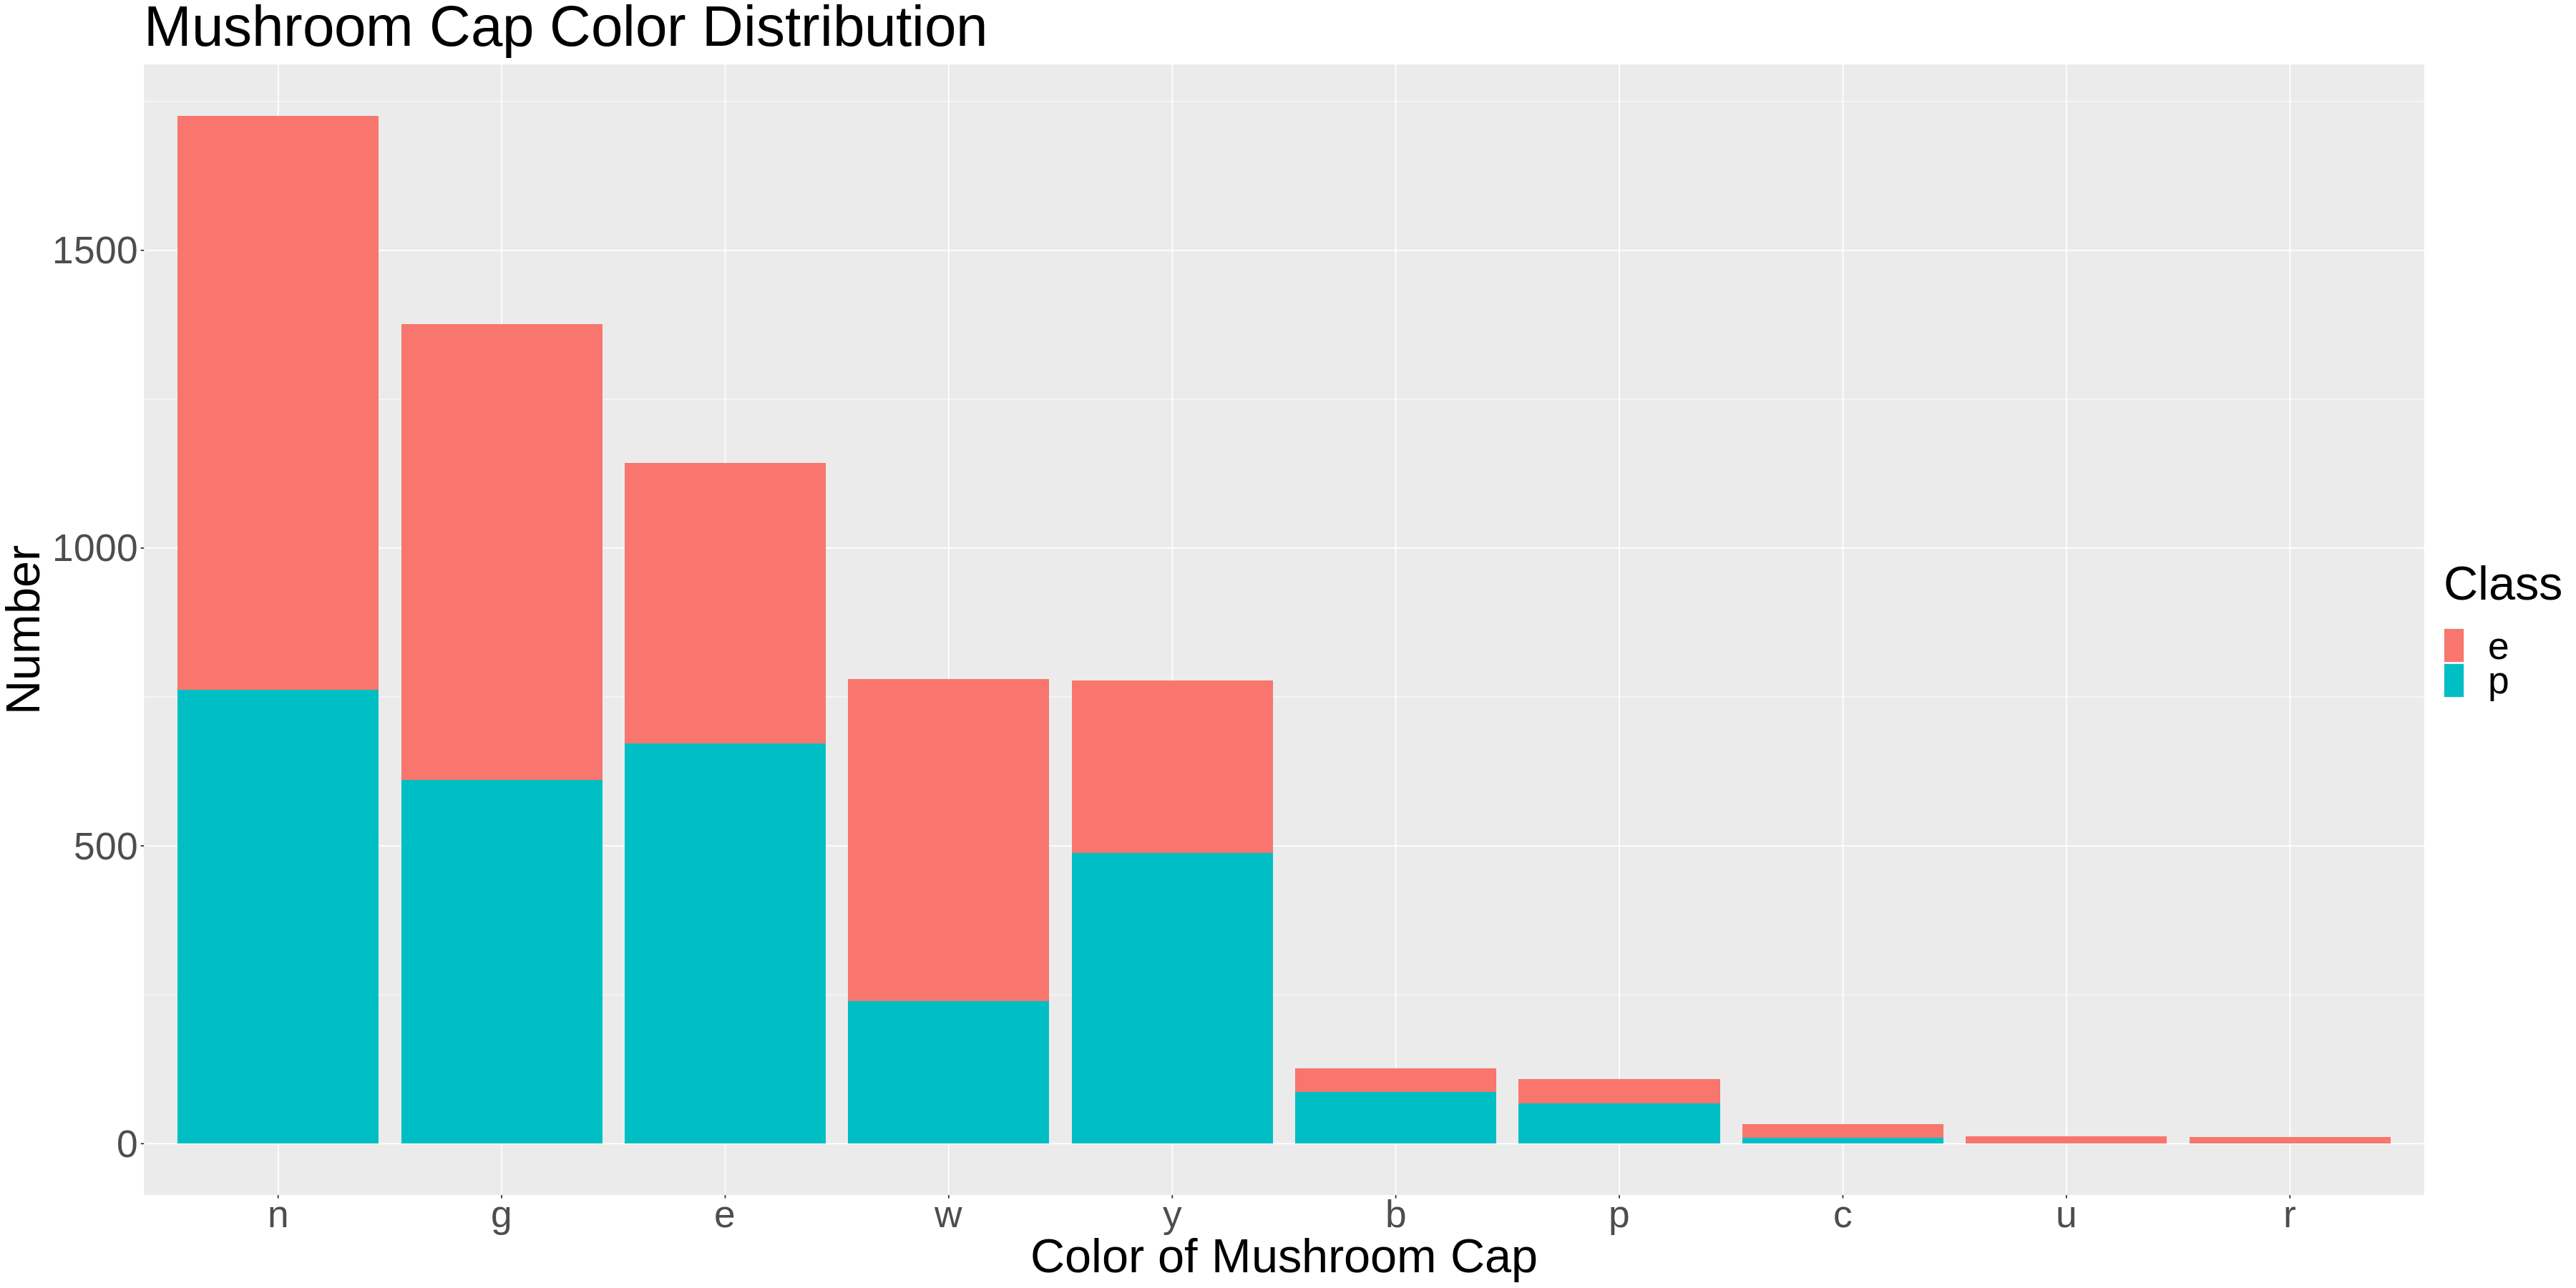

In [127]:
cap_color <- count(mushroom_train, class, cap_color)
cap_color
cap_color_plot <- cap_color |>
ggplot(aes(x= reorder (cap_color, -n), y= n, fill = class)) +
geom_bar(stat = "identity") + 
    xlab("Color of Mushroom Cap") +
    ylab("Number") +
    labs(fill = "Class") +
    ggtitle("Mushroom Cap Color Distribution")+
    theme(text = element_text(size = 40))
options(repr.plot.width = 30, repr.plot.height = 15)
cap_color_plot

class,odor,n
<chr>,<chr>,<int>
e,a,292
e,l,298
e,n,2566
⋮,⋮,⋮
p,p,188
p,s,440
p,y,423


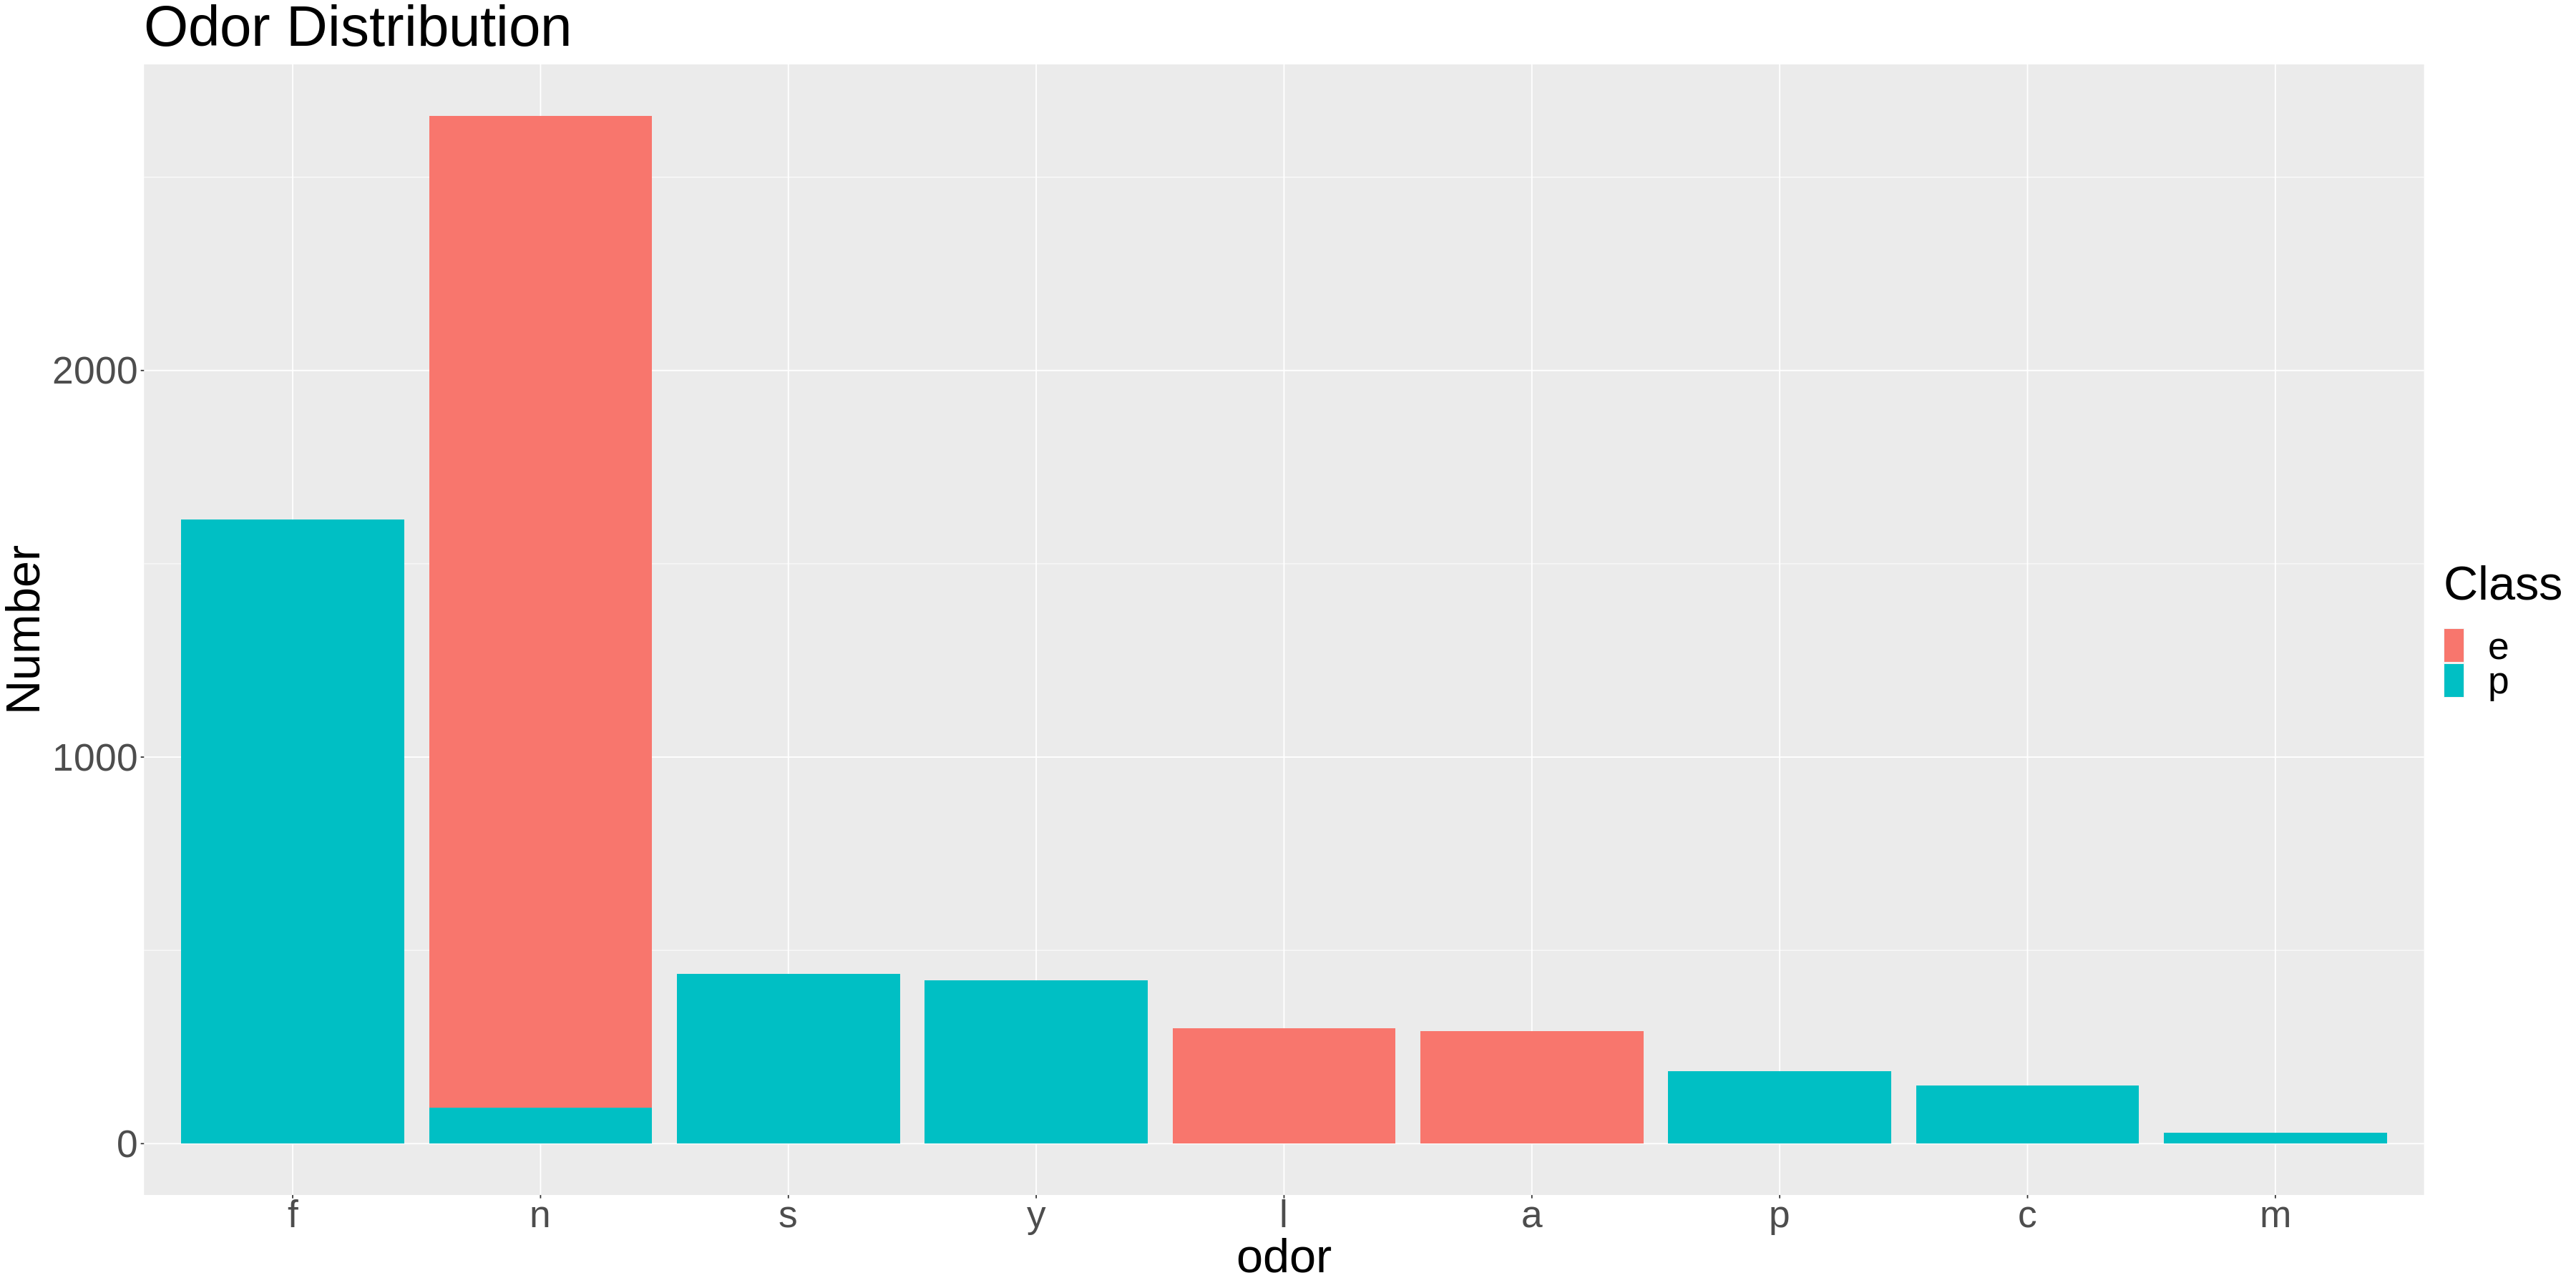

In [128]:
odor <- count(mushroom_train, class, odor)
odor
odor_plot <- odor |>
ggplot(aes(x= reorder (odor, -n), y= n, fill = class)) +
geom_bar(stat = "identity") + 
    xlab("odor") +
    ylab("Number") +
    labs(fill = "Class") +
    ggtitle("Odor Distribution")+
    theme(text = element_text(size = 40))
options(repr.plot.width = 30, repr.plot.height = 15)
odor_plot

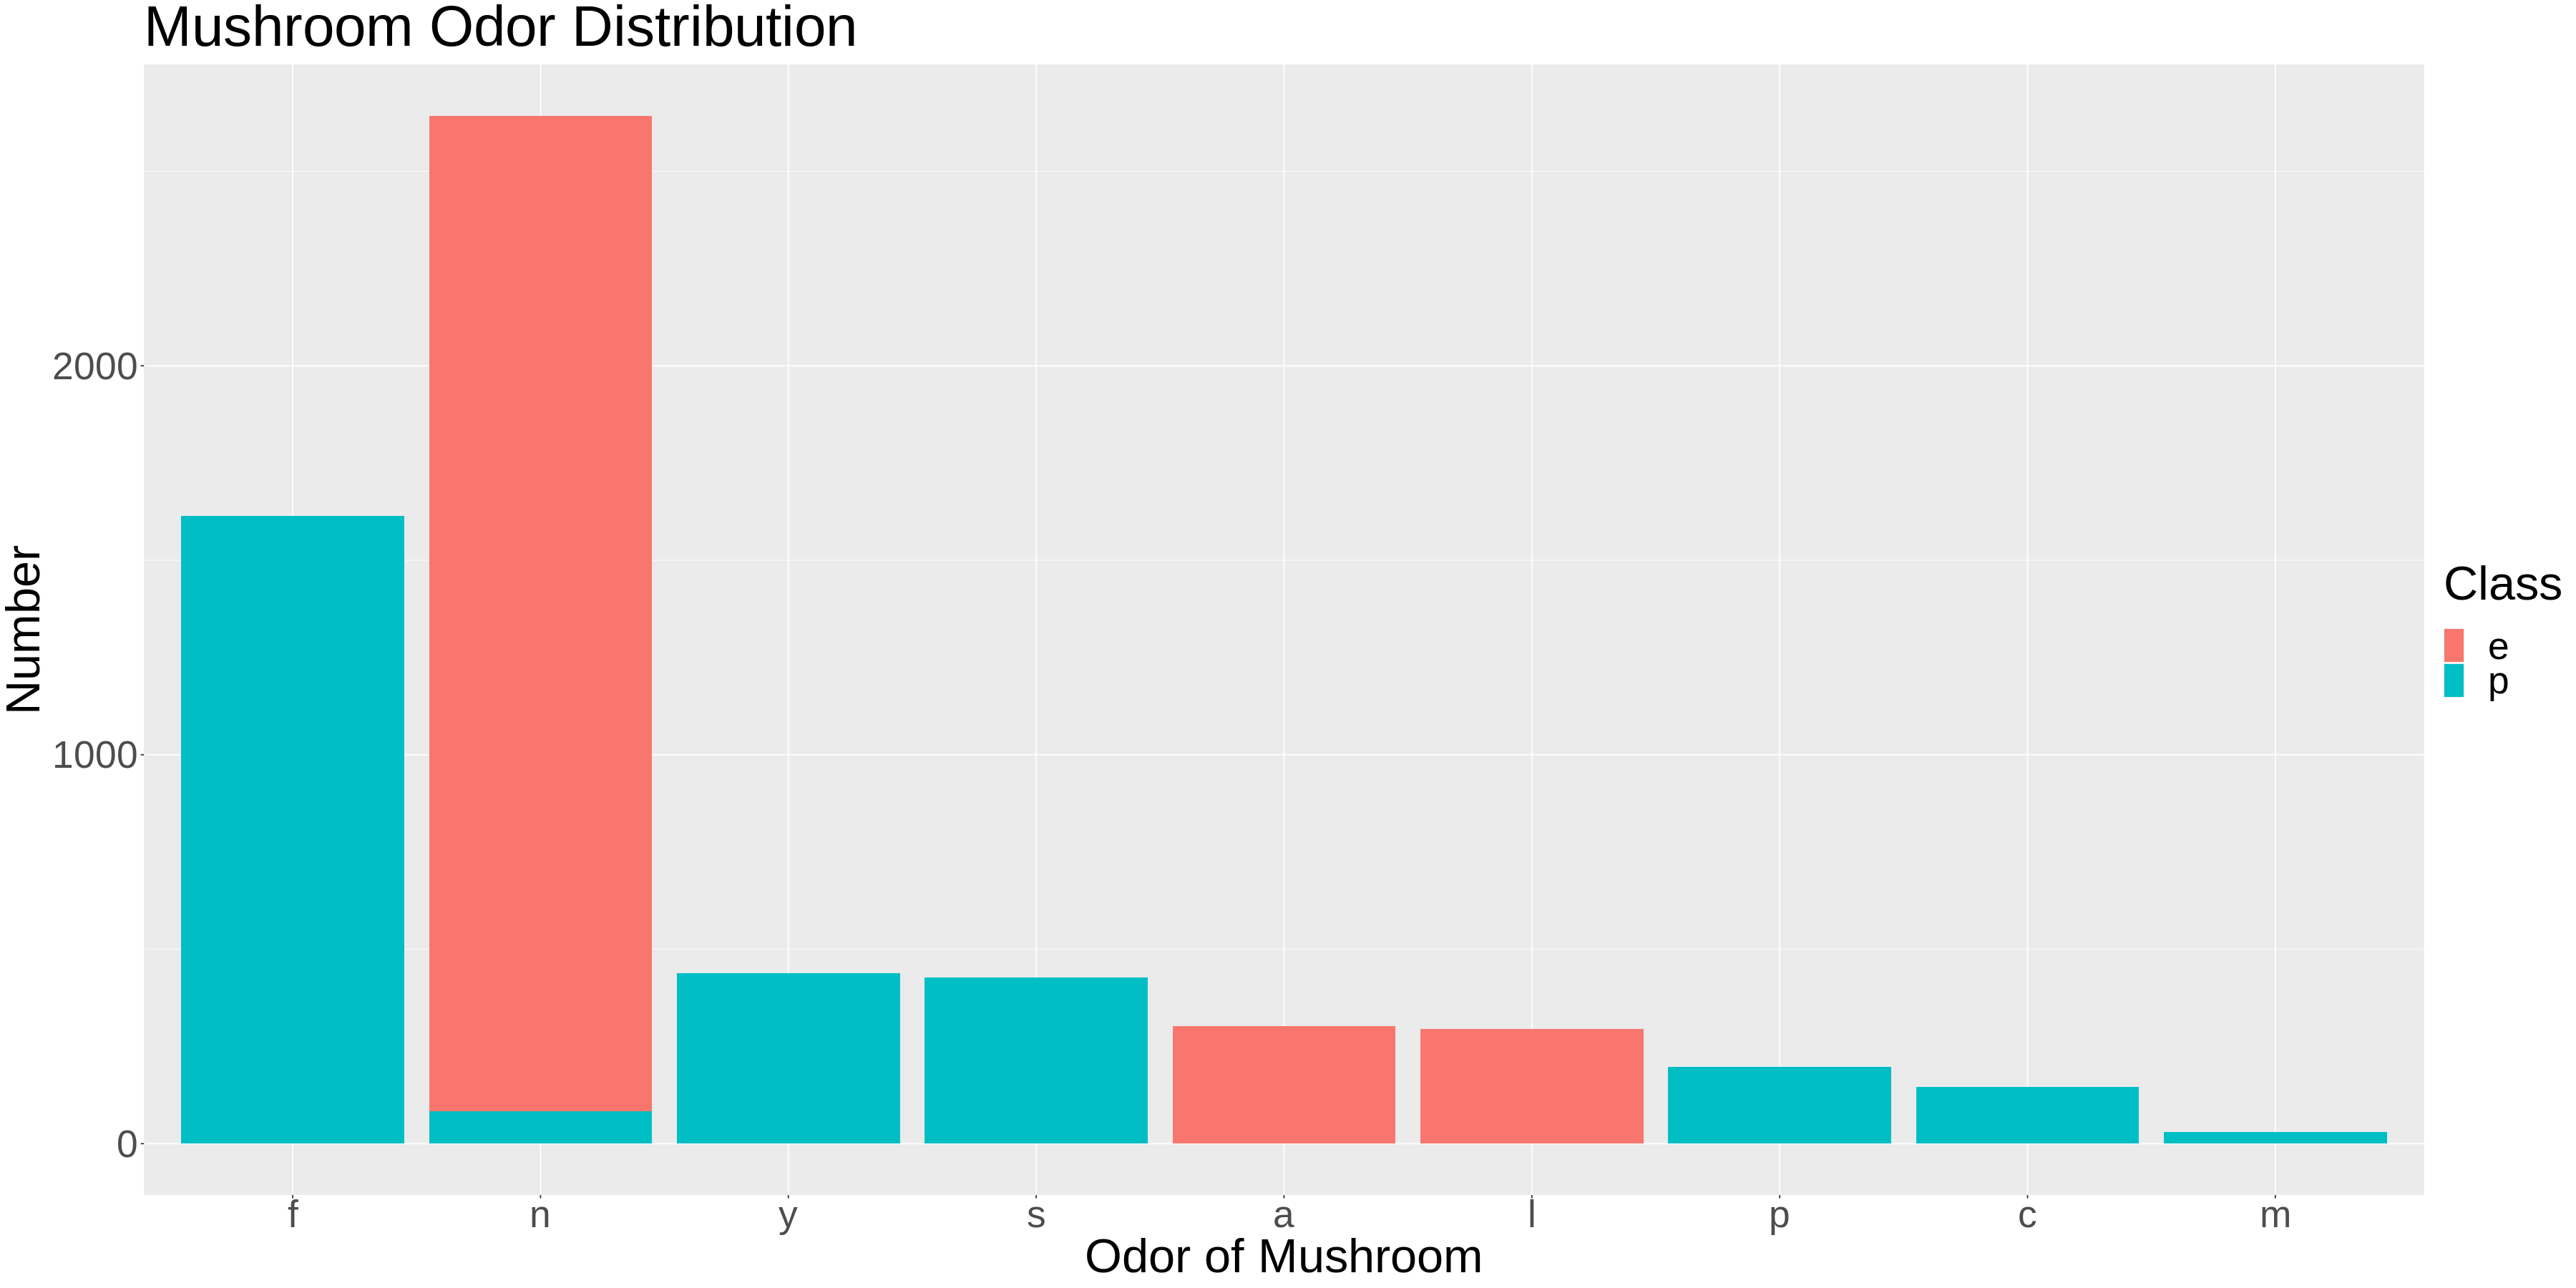

In [16]:
odor_plot <- odor |>
ggplot(aes(x= reorder (odor, -n), y= n, fill = class)) +
geom_bar(stat = "identity") + 
    xlab("Odor of Mushroom") +
    ylab("Number") +
    labs(fill = "Class") +
    ggtitle("Mushroom Odor Distribution")+
    theme(text = element_text(size = 40))
options(repr.plot.width = 30, repr.plot.height = 15)
odor_plot